In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate
import pandas as pd

pi = np.pi
MeV_to_km = 1.323e-6
Mo_to_km = 1.4766

p_c = 4.42e-5 # km^-2

In [2]:
# read in our data
# The files contain n[0.16 fm^-3], p[Mev/fm^-3] and eps [Mev/fm^-3]

EOS_1 = pd.read_table('../data/3952.dat', header=None)
EOS_2 = pd.read_table('../data/8663.dat', header=None)
EOS_3 = pd.read_table('../data/13022.dat', header=None)

# grab p and e then convert them to km^-2

p_1 = MeV_to_km*EOS_1[1].to_numpy()
e_1 = MeV_to_km*EOS_1[2].to_numpy()

p_2 = MeV_to_km*EOS_2[1].to_numpy()
e_2 = MeV_to_km*EOS_2[2].to_numpy()

p_3 = MeV_to_km*EOS_3[1].to_numpy()
e_3 = MeV_to_km*EOS_3[2].to_numpy()

In [3]:
def ODE_2(y, p, EOS_e):
    """
    Function that characterizes the ODE we are solving.
    """
    
    dy = np.zeros(y.shape)
    
    num0 = -2*y[0]*(np.sqrt(y[0])-2*y[1])
    den0 = (EOS_e(p)+p)*(y[1]+4*pi*p*y[0]**(3/2))
    
    dy[0] = num0/den0
    
    num1 = -4*np.pi*EOS_e(p)*(y[0]**(3/2))*(np.sqrt(y[0])-2*y[1])
    den1 = (EOS_e(p)+p)*(y[1]+4*pi*p*y[0]**(3/2))
    
    dy[1] = num1/den1
    
    num2 = (y[2]**2 + y[2]*F_ode(p, y[0], y[1], EOS_e)
            + yQ_ode(p, y[0], y[1], EOS_e) )*(np.sqrt(y[0])-2*y[1])
    den2 = (EOS_e(p)+p)*(y[1]+4*pi*p*y[0]**(3/2))
    
    dy[2] = num2/den2
    
    return dy

In [4]:
def F_ode(p, y, m, EOS_e):
    
    a = np.sqrt(y)/(np.sqrt(y)-2*m)
    b = 4*pi*(EOS_e(p)-p)
    return a*(1-b)

def yQ_ode(p, y, m, EOS_e):
        
    a = 4*pi*y*np.sqrt(y)
    b = np.sqrt(y)-2*m
    
    one = (a/b)*(5*EOS_e(p) + 9*p + EOS_e.derivative(nu=1)(p)*(EOS_e(p)+p))
    two = -6*np.sqrt(y)/b
    three = -4*( m/b + a*p/b )**2
    
    return one+two+three

In [5]:
def k_2(C, x_R):
    num = ((1 - 2*C)**2)*(2 - x_R + 2*C*(x_R-1))
    
    a = 6 - 3*x_R + 3*C*(5*x_R - 8)
    b = 13 - 11*x_R + C*(3*x_R-2) + (2*C**2)*(1+x_R)
    c = 2 - x_R + 2*C*(x_R-1)
    
    den = 2*C*a + 4*(C**3)*b + 3*((1-2*C)**2)*c*np.log(1-2*C)
    
    return (8*(C**5)*num)/(5*den)

def big_lamb(k2, R, M):
    """
    k2: dimensionless tidal Love number
    R: radius of NS in km
    M: mass of NS in Mo (solar masses)
    """
    return (2/3)*k2*((R/(1.4766*M))**5)

In [24]:
EOS1_e = scipy.interpolate.CubicSpline(p_1, e_1)

t0 = p_c
y0 = np.array([1e-7,1e-10,2])
tf = 1e-10*t0

size = int(1e3)
t = np.linspace(t0, tf, size)

sol = scipy.integrate.odeint(ODE_2, y0, t, args=(EOS1_e,))

pressure = t/MeV_to_km
radius = np.sqrt(sol[:,0])
mass = sol[:,1]/Mo_to_km
x = sol[:,2]

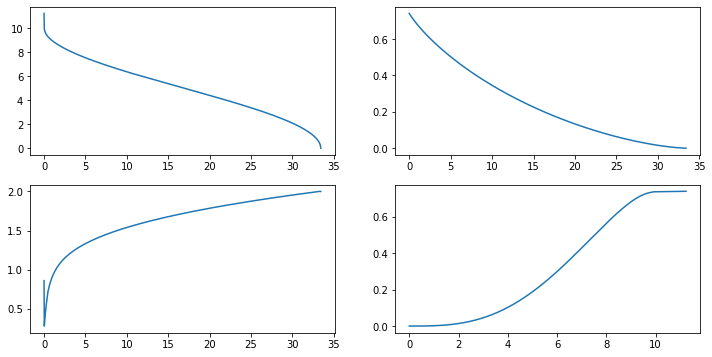

In [25]:
fig, ax = plt.subplots(2,2, figsize=(12,6))

ax[0,0].plot(pressure, radius)
ax[0,1].plot(pressure, mass)
ax[1,0].plot(pressure, x)
ax[1,1].plot(radius, mass)